In [ ]:
import os
import base64
from PIL import Image
from io import BytesIO
from IPython.display import display
from datasets import load_dataset
import os
import pandas as pd 

from byaldi import RAGMultiModalModel

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

In [38]:
with open('hf_key.txt', 'r') as file:
    hf_key = file.read().strip()

with open("openai_api_key.txt", "r") as file:
    openai_key = file.read().strip()

os.environ["HF_TOKEN"] = hf_key
os.environ["OPENAI_API_KEY"] = openai_key

## Dataset 

In [ ]:
# Load the dataset
dataset = load_dataset("ibm/finqa", trust_remote_code=True)

# Access the splits
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

In [ ]:
train_data = pd.DataFrame(train_data)
train_data.set_index('id', inplace=True)
train_data = train_data[["question", "answer"]]

In [ ]:
train_data["Company"] = [row[0] for row in train_data.index.str.split("/")]
train_data["Year"] = [row[1] for row in train_data.index.str.split("/")]
train_data.head(5)

In [43]:
example = train_data.iloc[0]
example

question    what is the the interest expense in 2009?
answer                                            380
Company                                           ADI
Year                                             2009
Name: ADI/2009/page_49.pdf-1, dtype: object

## Indexing 

In [32]:
try:
    RAG = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v1.0", device="mps")
    RAG.index(
        input_path="docs/ADI/2009/", # The path to your documents
        index_name="test", # The name you want to give to your index. It'll be saved at `index_root/index_name/`.
        store_collection_with_index=True, # Whether the index should store the base64 encoded documents.
        overwrite=True # Whether to overwrite an index if it already exists. If False, it'll return None and do nothing if `index_root/index_name` exists.
    )
except Exception as e:
    RAG.from_index("test", device="mps")

Added page 1 of document 34 to index.
Index exported to .byaldi/test
Index exported to .byaldi/test


In [42]:
query = example["question"]

results = RAG.search(query, k=3)
query

'what is the the interest expense in 2009?'

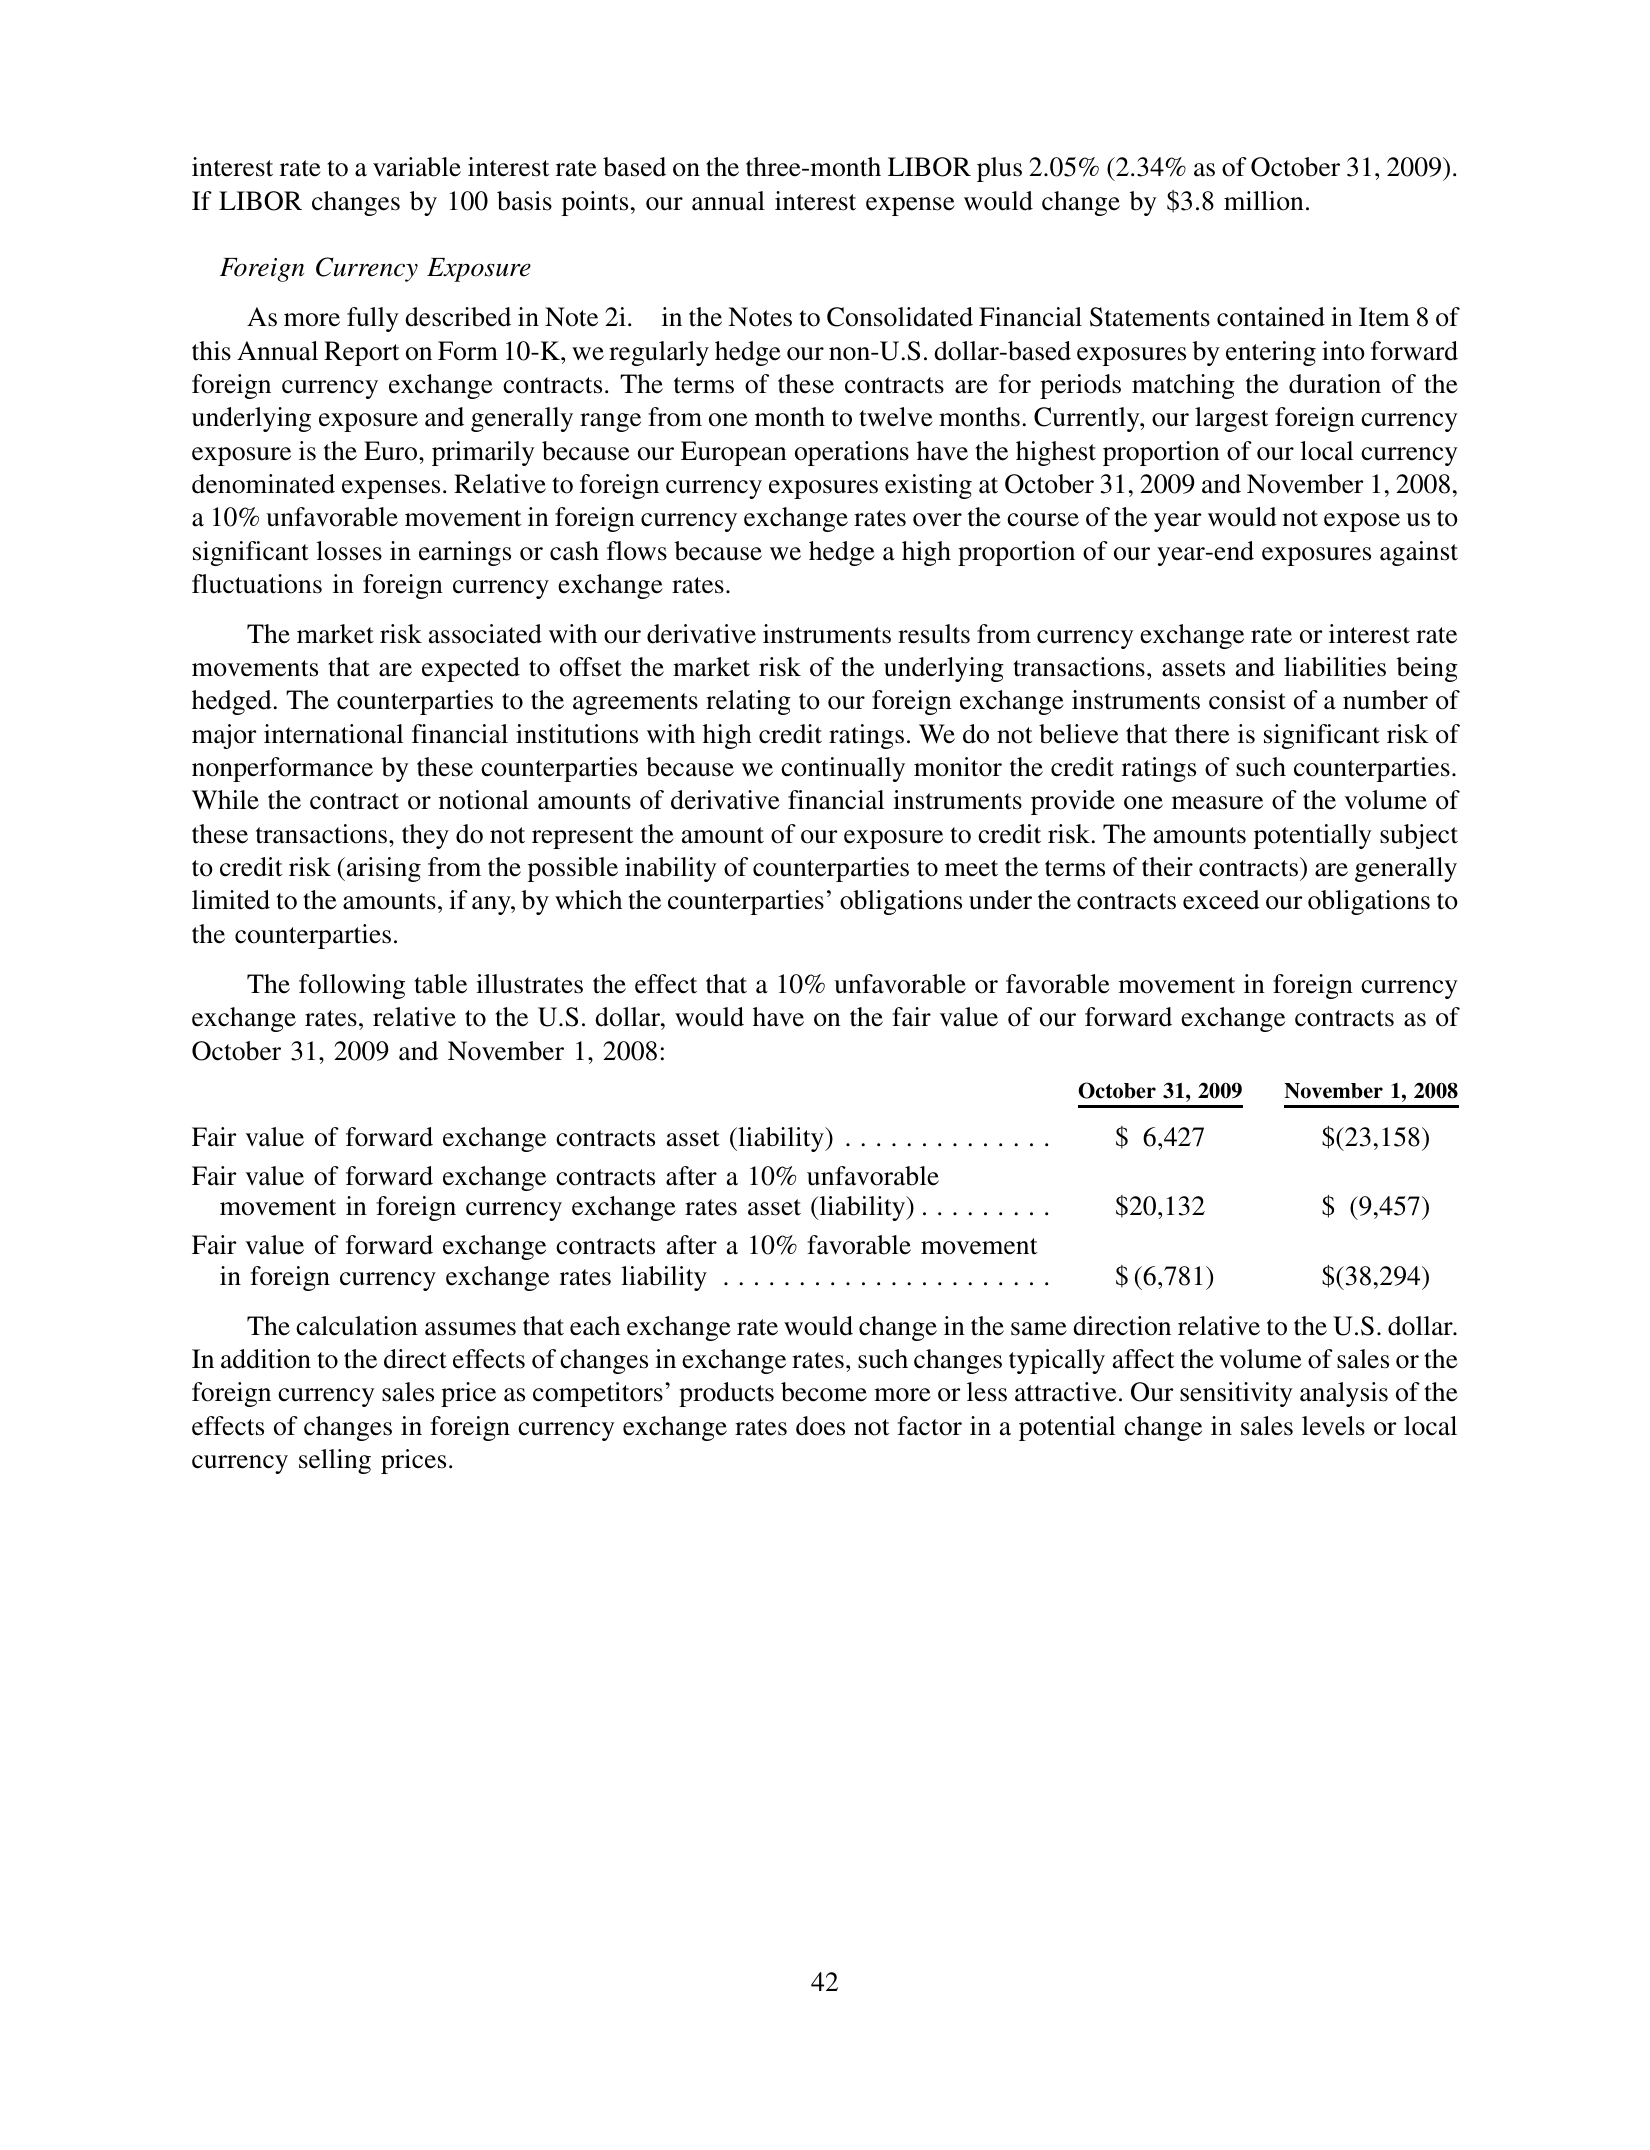

In [44]:
# Decode the base64 string
image_data = base64.b64decode(results[0]['base64'])

# Convert the bytes to an image
image = Image.open(BytesIO(image_data))

# Display the image in the notebook
display(image)

In [39]:
model = ChatOpenAI(model="gpt-4o")

In [40]:
message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/pdf;base64,{results[0]['base64']}"},
        },
    ],
)

response = model.invoke([message])

In [41]:
response.content

'The interest expense for 2009 is not directly provided on this page. You may need to check other sections of the document, such as the income statement or notes to financial statements, for that specific information.'